In [1]:
import os
import sys
import jax
import jax.numpy as np
import jax.tree as jtu
import jax.random as jr

# Basic jax import
jax.config.update("jax_enable_x64", True)

# Check if running on remote, and set directory to where notebook is run
if jax.devices()[0].platform == "gpu":
    os.chdir("code/amigo_project/notebooks/calibration")

# Add parent directories
paths = [os.path.abspath(os.path.join(os.getcwd(), path)) for path in ["..", "../.."]]
for path in paths:
    if path not in sys.path:
        sys.path.insert(0, path)

ERROR:2025-05-21 22:42:17,365:jax._src.xla_bridge:647: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/louis/miniconda3/envs/jax_gpu/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 645, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/louis/miniconda3/envs/jax_gpu/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 105, in initialize
    triton.register_compilation_handler(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jax._src.lib.triton' has no attribute 'register_compilation_handler'


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
        
# Plotting set up
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = mpl.colormaps["inferno"]
seismic = mpl.colormaps["seismic"]
coolwarm = mpl.colormaps["coolwarm"]


inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
coolwarm.set_bad("k", 0.5)


### The Data checklist

- [ ] Filter
    - Currently, only F380M, F430M, F480M and currently supported
- [ ] Number of groups
    - It is important to note that we lose the first group when taking slopes, so 1 / ngroups worth of signal is lost
    - Low group count data can also look like it has a poor statistical fit, due to being dominated by uncalibrated pixel-to-pixel effects below the noise floor of the calibration data
- [ ] Pixel depth
    - Under 20k DN (the output unit of calslope data) is safe, over 30k is bad
    - Note that the sum of the slopes misses the first group, so low group data can go deeper than expected
- [ ] Bad pixels 
    - Some will not be caught in the pipeline, so will need to be identified after the fit and re-flagged here
- [ ] Observations date 
    - Observations at different dates may have different mirror aberrations
- [ ] Dither Position 
    - Object observed away from the center of the array can have worse fits

In [3]:
from amigo.files import get_files

# Get the data
files = []
for file in get_files("../../data/calslope/GO1843/", "calslope"):
    header = file["PRIMARY"].header

    # Only look at the F380M, F430M, and F480M filters
    if header["FILTER"] not in ["F380M", "F430M", "F480M"]:
        continue

    file["BADPIX"].data[:, -1:] = 1
    file["BADPIX"].data[58, 67] = 1
    file["BADPIX"].data[-2:] = 1
    file["BADPIX"].data[4, 45] = 1
    file["BADPIX"].data[47, 32] = 1

    files.append(file)


# 100k per hour
cost_per_sec = 100e3 / (60**2)
duration = np.array([file["PRIMARY"].header["DURATION"] for file in files]).sum()
print(f"Duration: {duration / (60 ** 2):.2f} Hours")
print(f"Estimated: $ {cost_per_sec * duration * 1e-3:.0f}k")

Duration: 2.56 Hours
Estimated: $ 256k


# Now we build our exposures and construct our model

In [4]:
from amigo.core_models import AmigoModel
from amigo.optical_models import AMIOptics
from amigo.detector_models import SUB80Detector
from amigo.read_models import ReadModel
from amigo.model_fits import SplineVisFit
from amigo.vis_models import LogVisModel


# Get the exposures
exposures = [SplineVisFit(file, joint_fit=False) for file in files]

# Load the cached states
file_path = "../../GPU_files/"
load_dict = lambda x: np.load(f"{file_path}/{x}.npy", allow_pickle=True).item()

# Get the model
model = AmigoModel(
    exposures=exposures,
    optics=AMIOptics(),
    detector=SUB80Detector(),
    read=ReadModel(),
    vis_model=LogVisModel(load_dict("cal_files/vis_basis"), n_basis=420),
    state=load_dict("cal_files/cal_model"),
)

# Have a quick check to of the initial parameter guess fit

F430M Calibrator HD-205827 7


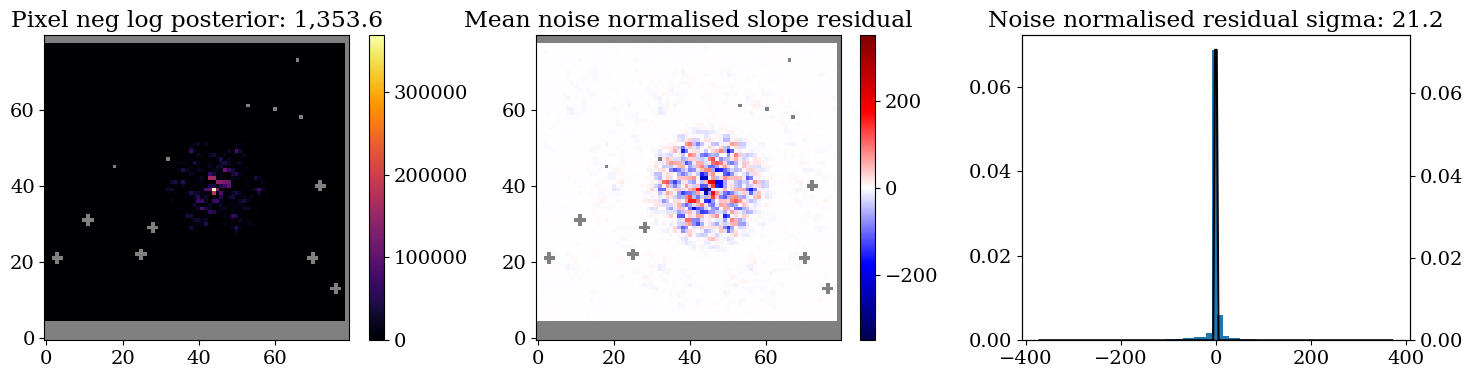

F380M Science HD-206893 4


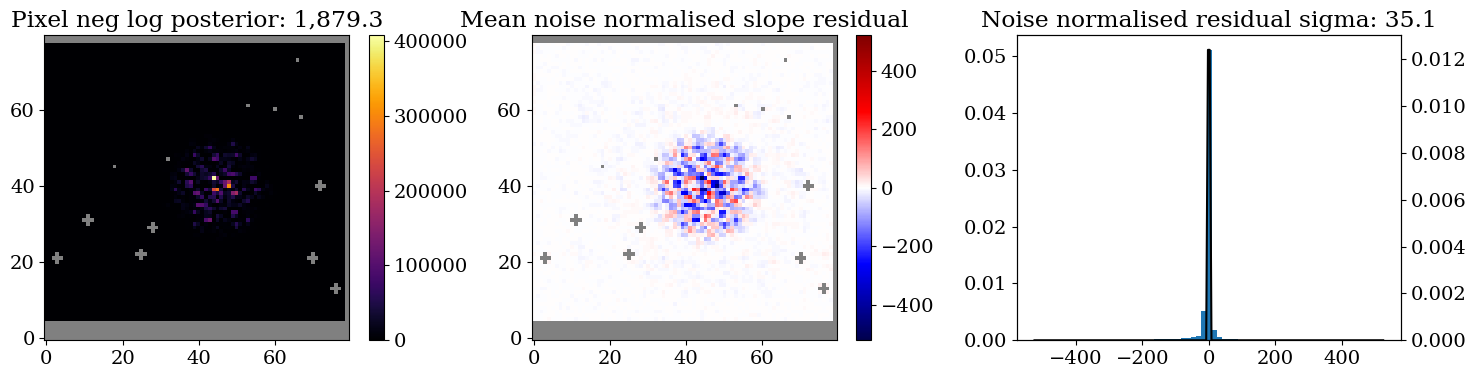

F480M Science HD-206893 11


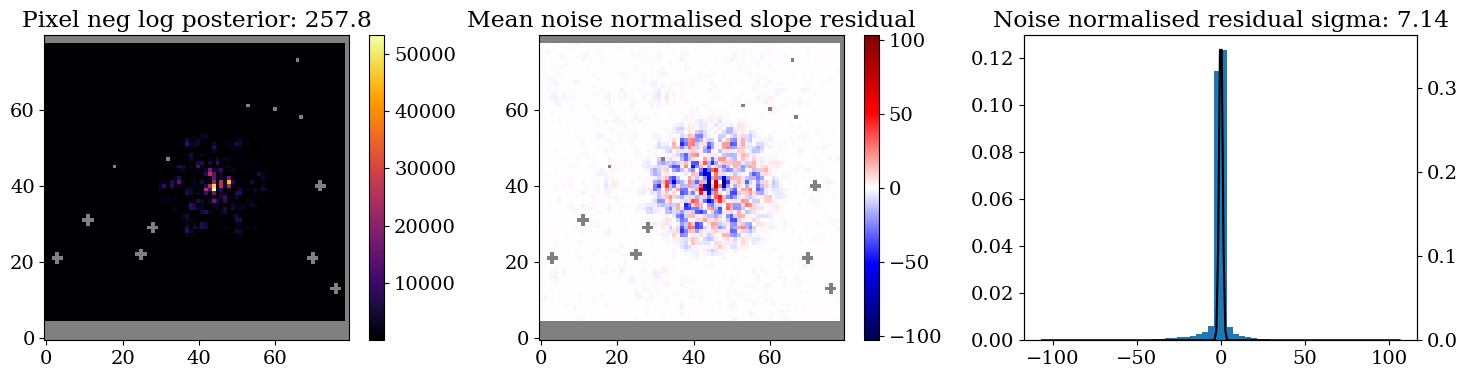

F480M Calibrator HD-205827 10


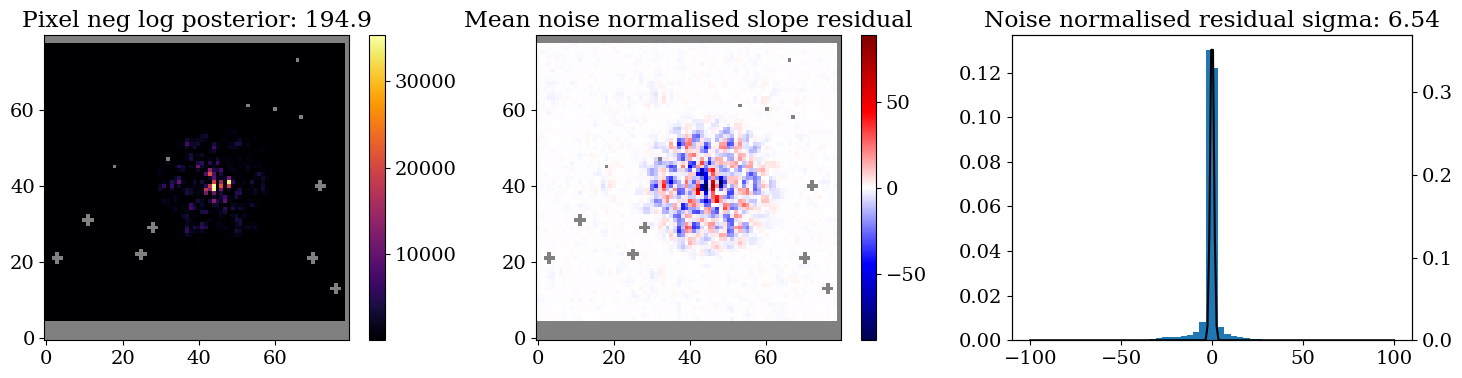

F430M Science HD-206893 8


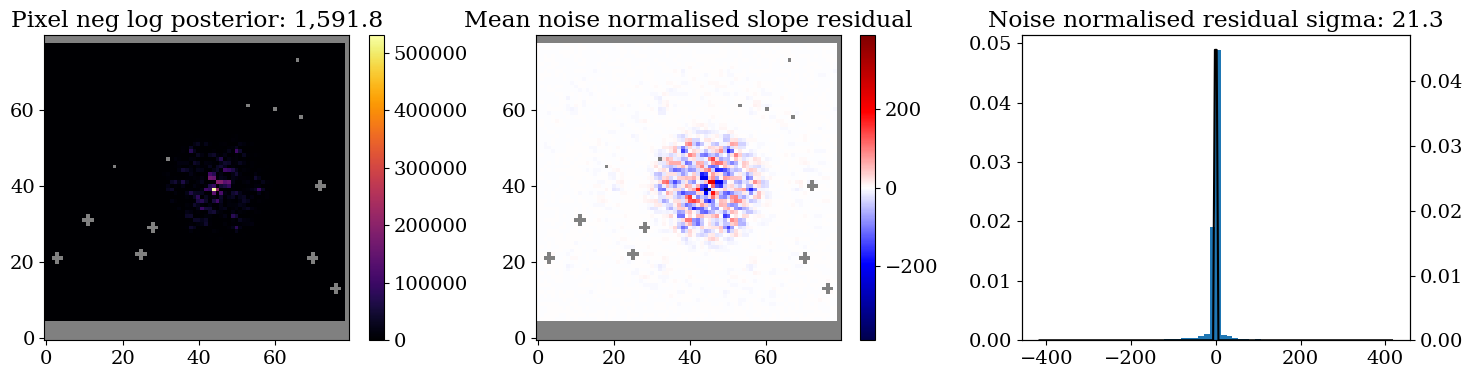

F380M Calibrator HD-205827 3


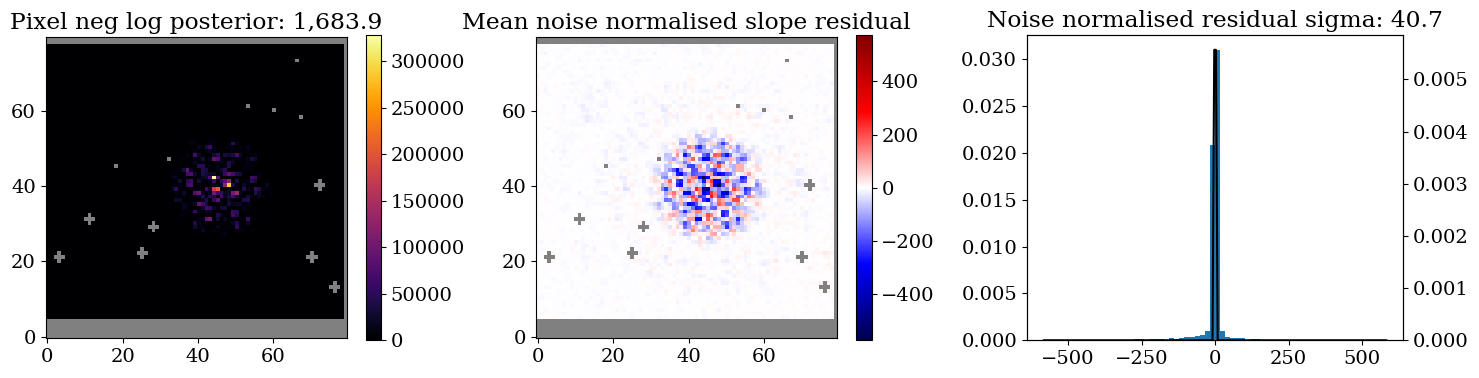

In [5]:
from amigo.plotting import summarise_fit

for exp in exposures:
    exp_type = "Calibrator" if exp.calibrator else "Science"
    print(exp.filter, exp_type, exp.star, exp.ngroups)
    summarise_fit(model, exp)#, residuals=True)

# Calibrated gradients & Fit the data

In [6]:
from amigo.fitting import Trainer, sgd, batch_exposures

optimisers = {
    "positions": sgd(1e-1, 0),
    "fluxes": sgd(5e-2, 5),
    "aberrations": sgd(1e-1, 10),
    "spectra": sgd(2e-1, 25),
    "amplitudes": sgd(2e0, 50),
    "phases": sgd(2e0, 50),
}

# Calibrate the gradients via the fisher matrix
trainer = Trainer().populate_fishers(
    model=model,
    exposures=exposures,
    hessians=load_dict("cal_files/jac_outputs")["hessian"],
    parameters=list(optimisers.keys()),
)

# Train the model
result = trainer.train(
    model=model,
    epochs=250,
    batches=batch_exposures(exposures, n_batch=2),
    optimisers=optimisers,
)

  0%|          | 0/250 [00:00<?, ?it/s]

Compiling Loss function...
Compiling Loss function...
Compiling update function...

Initial_loss Loss: 1,162.21
Estimated run time: 0:04:28
Full Time: 0:05:09
Final Loss: 9.93


# Examine our losses and parameter history

/tmp/ipykernel_1333388/4064298932.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


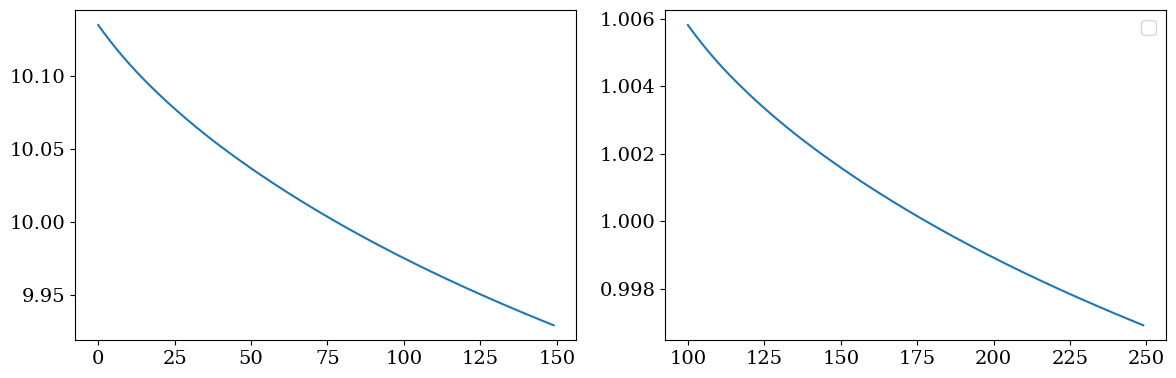

In [7]:
from amigo.plotting import plot

losses = np.array([v for v in result.losses.values()]).mean(0)

start = 100
stop = len(losses)
xs = np.arange(start, stop)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses[xs])
plt.subplot(1, 2, 2)

plt.plot(xs, np.log10(losses[xs]))
plt.legend()
plt.tight_layout()
plt.show()

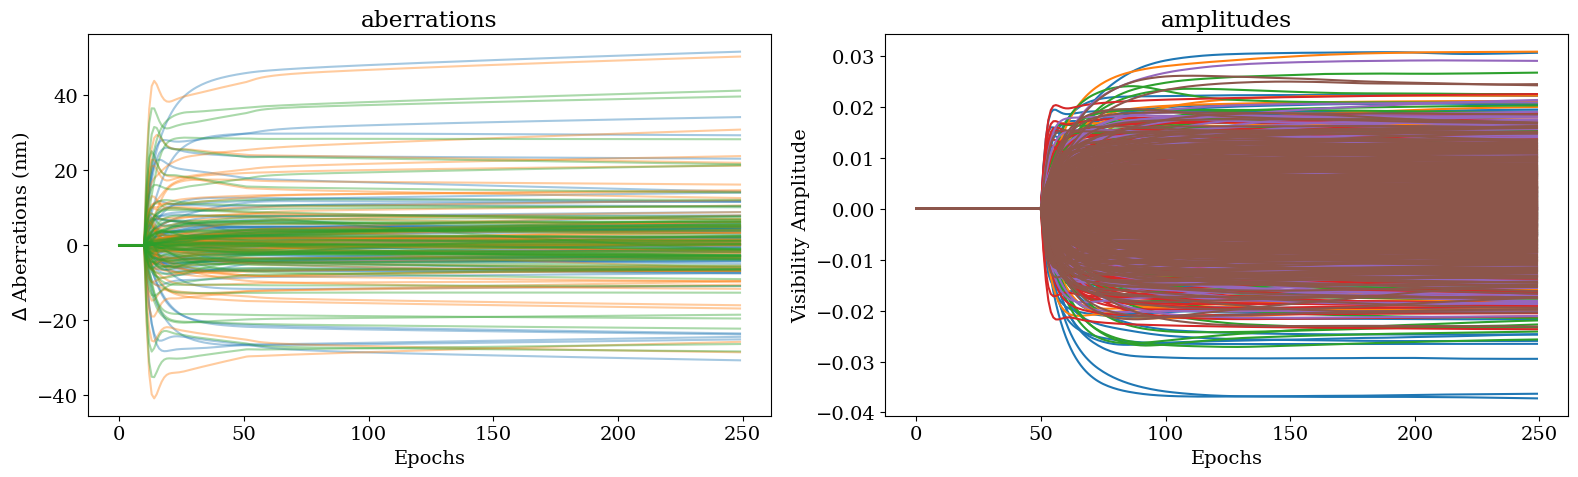

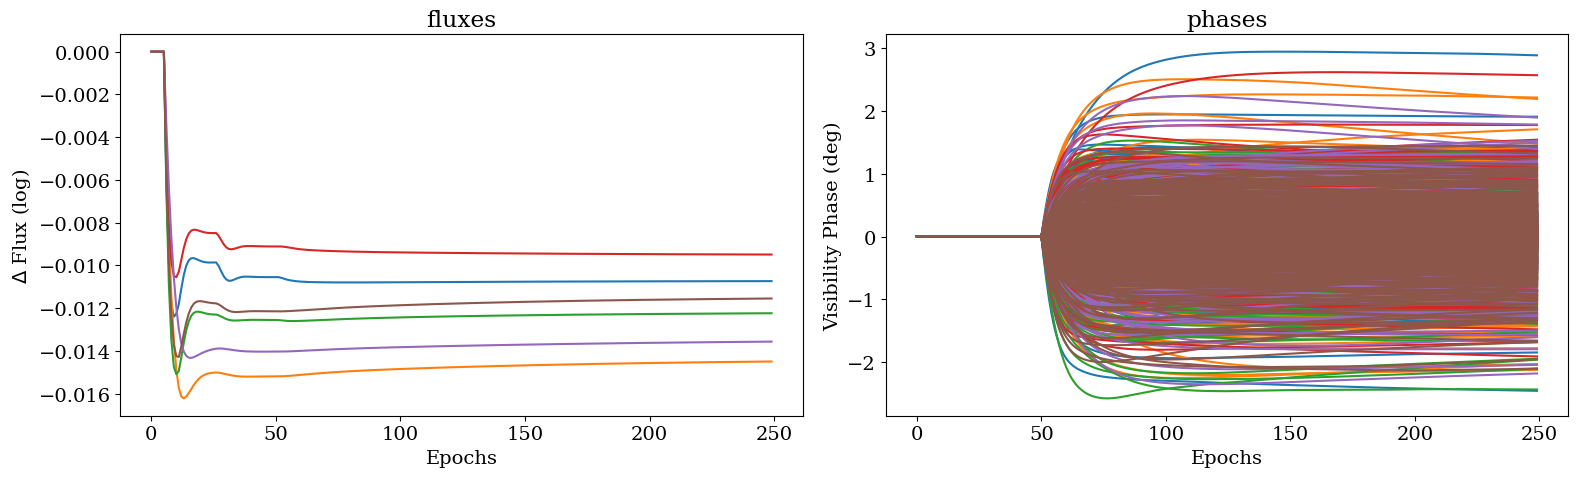

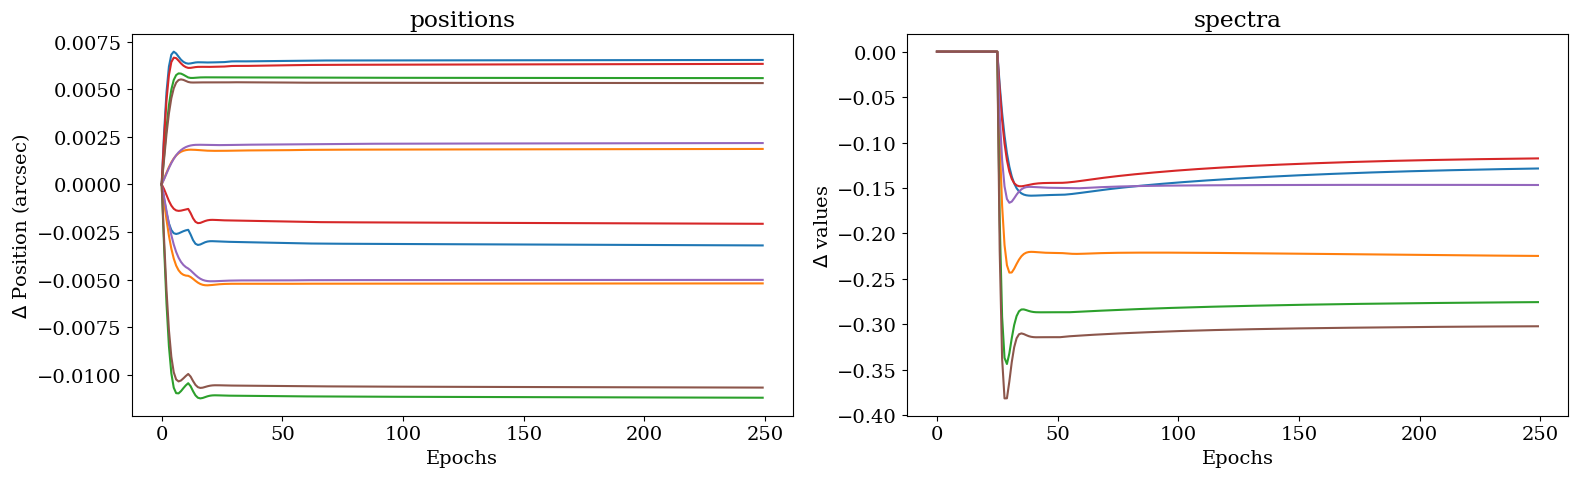

In [8]:
plot(result.history, start=0)#, end=5)

# EXPERIMENTAL: Final fit with BFGS

In [9]:
import equinox as eqx
import optimistix as optx
from amigo.core_models import ModelParams


def get_proj_mat(fmat):
    """Get the projection matrix for a Fisher matrix"""
    eig_vals, eig_vecs = np.linalg.eig(-fmat)
    return (eig_vals.real**-0.5)[:, None] * eig_vecs.real.T


proj_mats = jtu.map(get_proj_mat, trainer.fishers)

@eqx.filter_jit
def fun(params, args):
    model, exp, model_params, proj_mats, shapes = args

    # Project and add the parameters
    proj_params = jtu.map(lambda x, y: np.dot(x, y), proj_mats, params)
    model_params = jtu.map(lambda x, y: x + y, model_params, proj_params)
    model_params = jtu.map(lambda x, y: x.reshape(y), model_params, shapes)
    model = model_params.inject(model)

    # Return the loss
    return -np.nanmean(exp.mv_zscore(model))


params = ["amplitudes", "phases", "fluxes", "spectra"]
final_model = result.model

args_out = {}
sols_out = {}
for exp in exposures:
    opt_params = {}
    fishers = {}
    shapes = {}
    for param in params:
        key = exp.map_param(param)
        shapes[key] = final_model.get(key).shape
        opt_params[key] = final_model.get(key).flatten()
        fishers[key] = trainer.fishers[f"{exp.key}.{param}"]

    shapes = ModelParams(shapes)
    model_params = ModelParams(opt_params)
    initial_params = jtu.map(lambda x: np.zeros_like(x), model_params)
    proj_mats = jtu.map(get_proj_mat, ModelParams(fishers))
    proj_mats = jtu.map(lambda x: np.where(np.isnan(x) | np.isinf(x), 0, x), proj_mats)

    args = (final_model, exp, model_params, proj_mats, shapes)
    args_out[exp.key] = args

    try:
        print("Initial loss:", fun(initial_params, args))
    except Exception as e:
        print(f"Skipped {exp.key}")
        continue
    solver = optx.BFGS(rtol=1e-6, atol=1e-6)
    sol = optx.minimise(fun, solver, initial_params, args, throw=False, max_steps=2048)
    sols_out[exp.key] = sol

    print("Final loss:", fun(sol.value, args))
    print(sol.stats["num_steps"], sol.state.num_accepted_steps)
    print(optx.RESULTS[sol.result])
    print()

Initial loss: 7.356148172369385
Final loss: 7.352875335350349
488 232


Initial loss: 15.71175518382555
Final loss: 15.704897101135602
760 291


Initial loss: 6.923446320098686
Final loss: 6.923372508478958
616 221


Initial loss: 6.1696490917521105
Final loss: 6.169538815425851
381 161


Initial loss: 8.4261737072475
Final loss: 8.424321685172753
769 303


Initial loss: 14.984523370675799
Final loss: 14.975750325246754
931 336




# Update the model with the BFGS final parameters

In [10]:
spectra = {}
for key, args in args_out.items():
    proj_mats = args[3]
    proj_params = jtu.map(lambda x, y: np.dot(x, y), proj_mats, sols_out[key].value)
    model_params = jtu.map(lambda x, y: x + y, args[2], proj_params)
    model_params = jtu.map(lambda x, y: x.reshape(y), model_params, args[4])
    final_model = model_params.inject(final_model)

    # Spectra is joint-fit so we take the mean
    exp = args[1]
    spec = model_params.params[exp.map_param("spectra")]
    spec_key = exp.get_key("spectra")
    if spec_key not in spectra:
        spectra[spec_key] = [spec]
    else:
        spectra[spec_key].append(spec)

spectra = jtu.map(lambda x: np.array(x).mean(), spectra, is_leaf=lambda x: isinstance(x, list))
final_model = final_model.set("spectra", spectra)

final_state = {}
for key, values in result.state.items():
    final_state[key] = final_model.get(key)

# Check final fit

F380M Science HD-206893 4


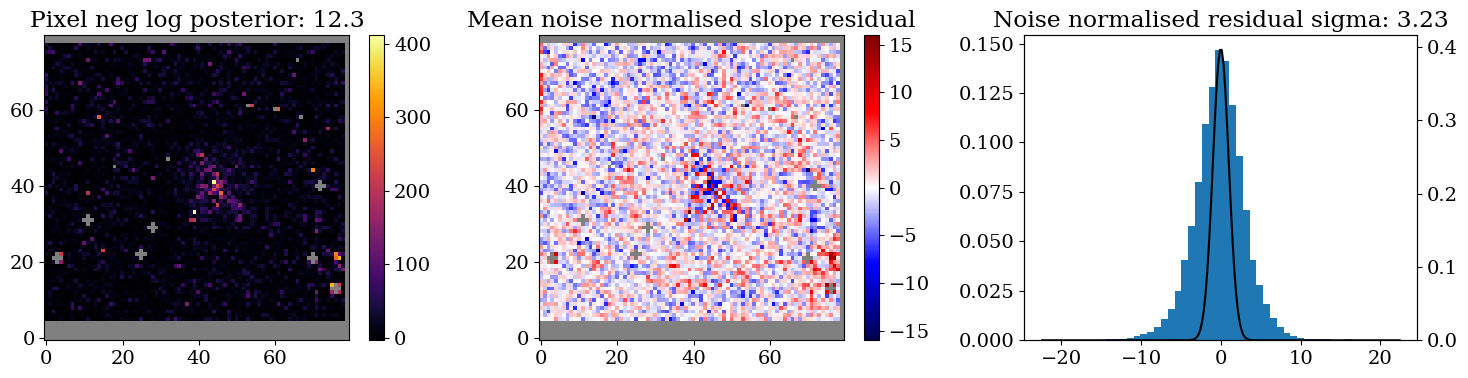

F380M Calibrator HD-205827 3


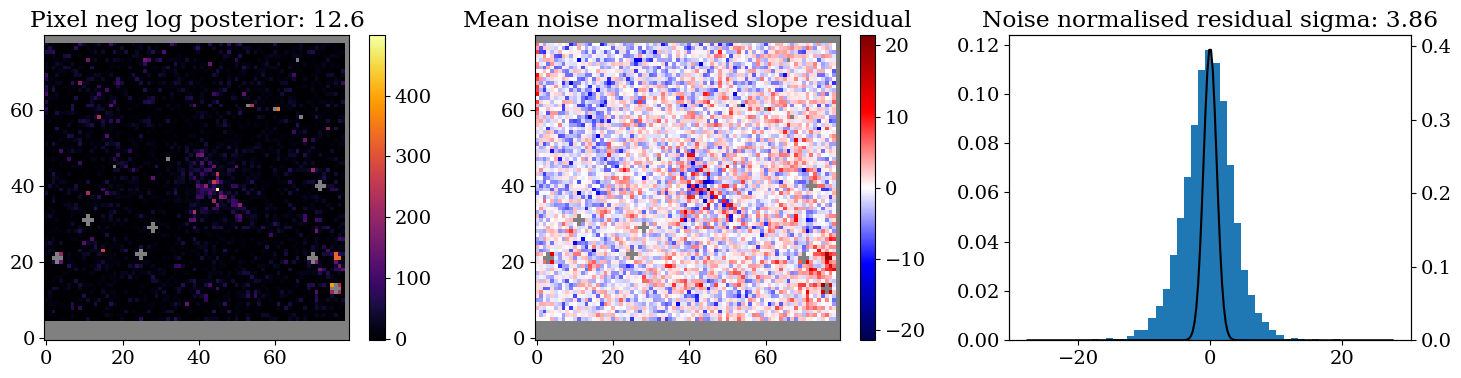

F430M Calibrator HD-205827 7


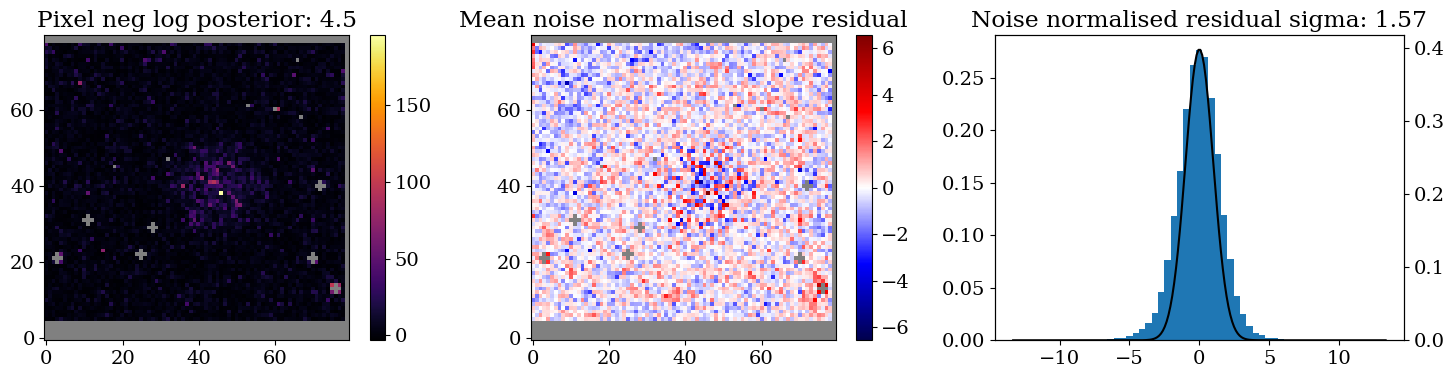

F430M Science HD-206893 8


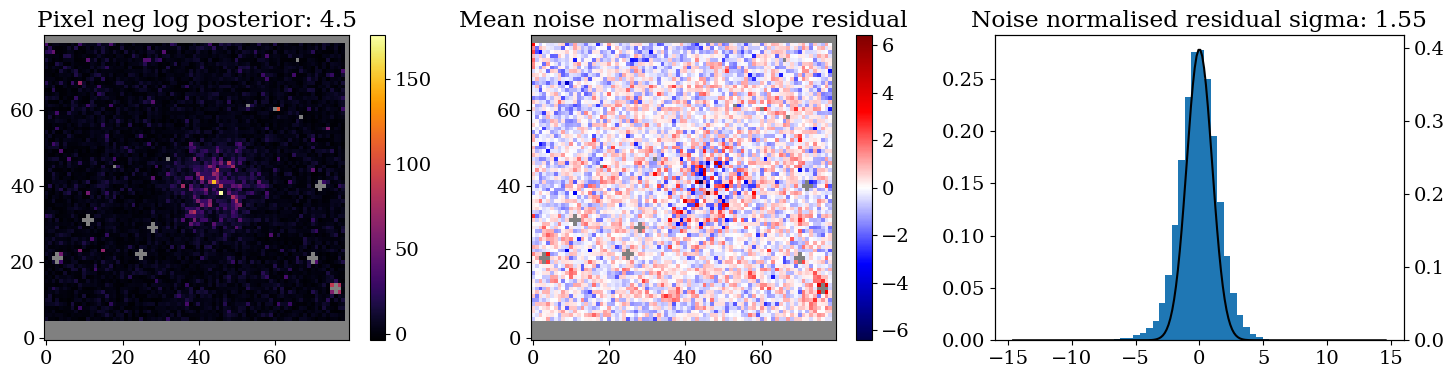

F480M Science HD-206893 11


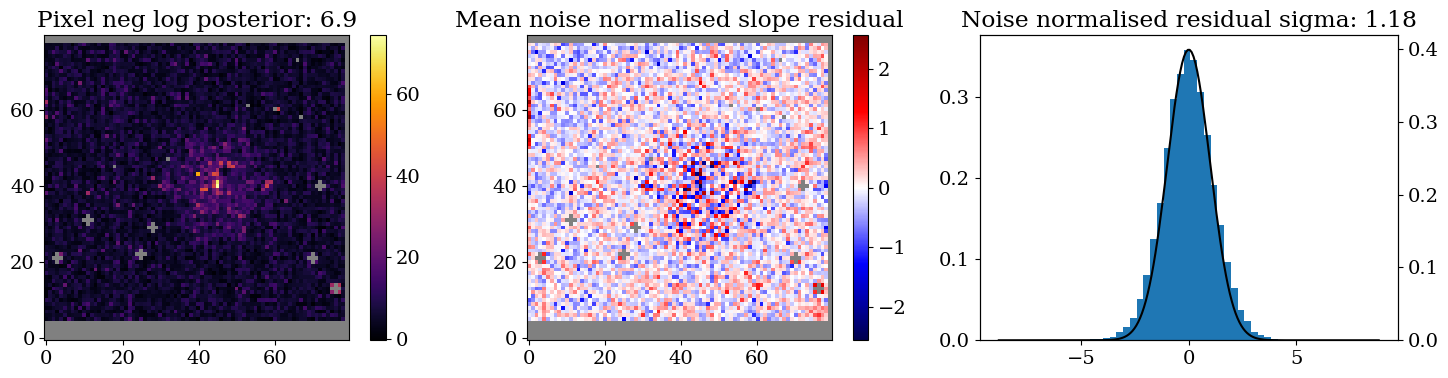

F480M Calibrator HD-205827 10


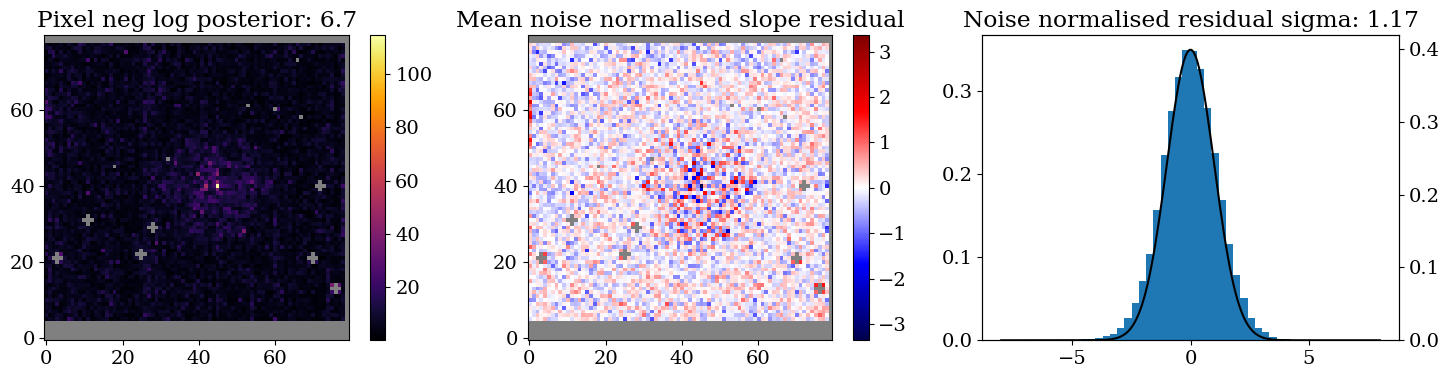

In [11]:
for filt in ["F380M", "F430M", "F480M"]:
    for exp in exposures:
        if exp.filter == filt:
            exp_type = "Calibrator" if exp.calibrator else "Science"
            print(exp.filter, exp_type, exp.star, exp.ngroups)
            summarise_fit(final_model, exp)

# Now calculate the Hessian of our loglikelihood to estimate the parameter uncertainty

In [12]:
import jax.tree as jtu
from tqdm.notebook import tqdm
from amigo.fisher import FIM


fmats = {}
for exp in tqdm(exposures):
    loglike_fn = lambda model: -np.nansum(exp.loglike(model))
    params = [exp.map_param("amplitudes"), exp.map_param("phases")]
    fmat = FIM(final_model, params, loglike_fn, reduce_ram=True, batch_size=20)
    fmats[exp.get_key("phases")] = fmat

  0%|          | 0/6 [00:00<?, ?it/s]

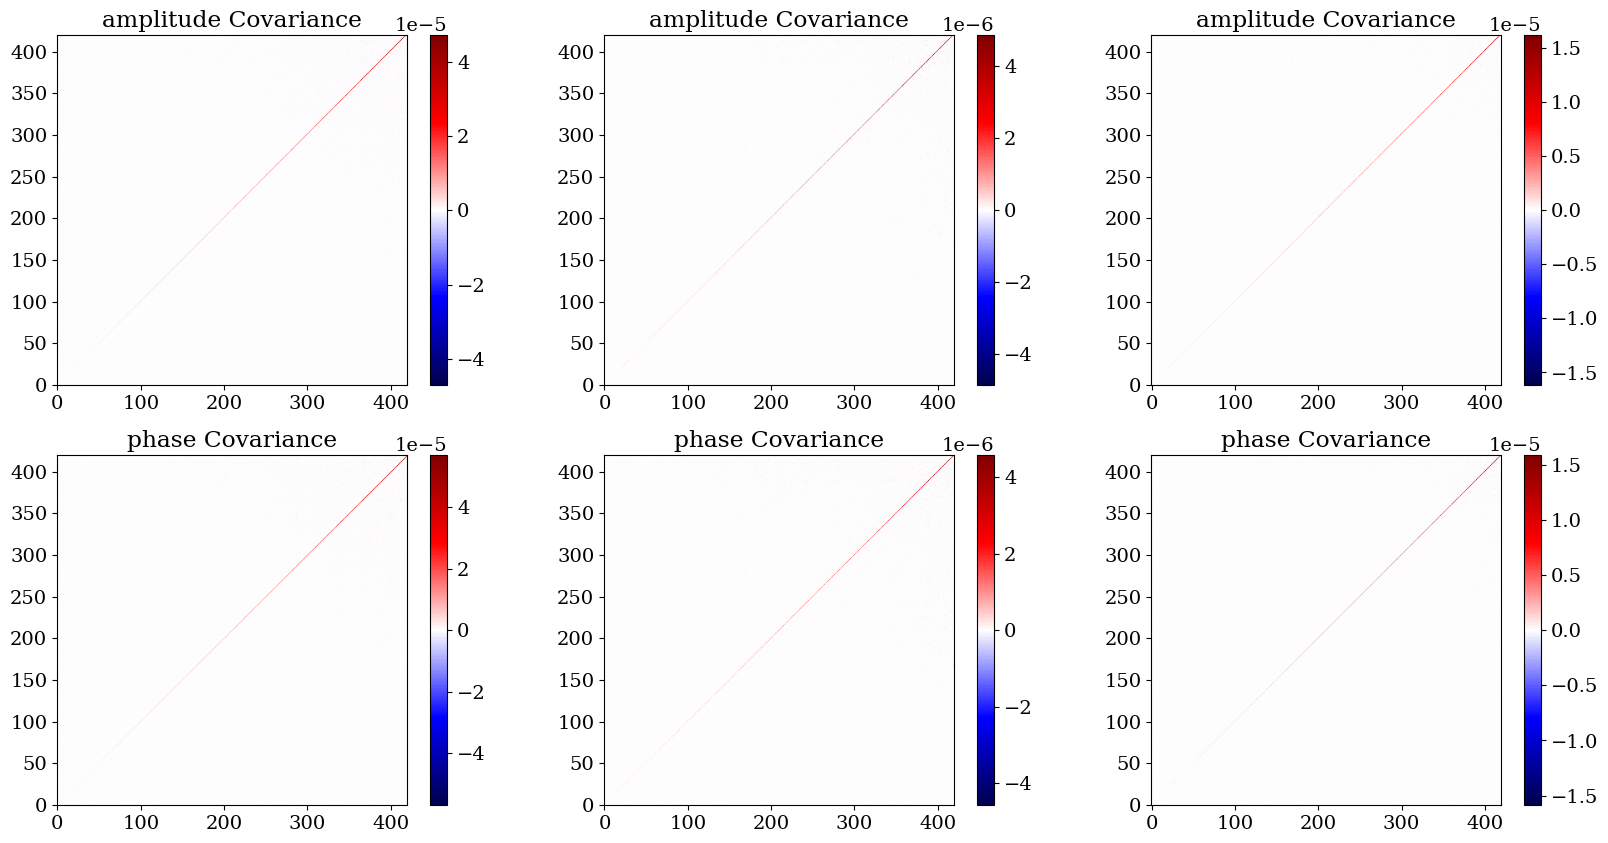

In [13]:
full_covs = jtu.map(lambda x: np.linalg.inv(x), fmats)

n = model.vis_model.n_basis
amp_covs = jtu.map(lambda x: x[:n, :n], full_covs)
phase_covs = jtu.map(lambda x: x[n:, n:], full_covs)

covs = {
    "amplitudes": amp_covs,
    "phases": phase_covs,
}

plt.figure(figsize=(20, 10))
for i, key in enumerate(amp_covs):
    if i > 5:
        break

    if i < 3:
        param = "amplitude"
        cov = amp_covs[key]
    else:
        param = "phase"
        cov = amp_covs[key]
    plt.subplot(2, 3, i + 1)
    plt.title(f"{param} Covariance")
    v = np.nanmax(np.abs(cov))
    plt.imshow(cov, seismic, vmin=-v, vmax=v)
    # plt.imshow(np.log10(np.abs(cov)), inferno)
    plt.colorbar()
plt.show()

# Finally, save our fit outputs

In [ ]:
fit_outputs = {
    "n_basis": final_model.vis_model.n_basis,
}

for exp in exposures:
    get_fn = lambda param: final_model.get(exp.map_param(param))
    fit_outputs[exp.key] = {
        "star": exp.star,
        "calibrator": exp.calibrator,
        "filter": exp.filter,
        "parang": exp.parang,
        "defocus": final_model.get(exp.map_param("defocus")),
        "n_basis": final_model.vis_model.n_basis,
        "fishers": fmats[exp.get_key("phases")],
        "amp_cov": amp_covs[exp.get_key("phases")],
        "phase_cov": phase_covs[exp.get_key("phases")],
        **{param: get_fn(param) for param in final_state.keys()},
    }

np.save(f"{file_path}/results/GO1843/fit_outputs", fit_outputs, allow_pickle=True)

: 